In [2]:
!mkdir facades
!unzip archive\ \(2\).zip -d facades

mkdir: cannot create directory ‘facades’: File exists
Archive:  archive (2).zip
  inflating: facades/metadata.csv    
  inflating: facades/testA/1.jpg     
  inflating: facades/testA/10.jpg    
  inflating: facades/testA/100.jpg   
  inflating: facades/testA/101.jpg   
  inflating: facades/testA/102.jpg   
  inflating: facades/testA/103.jpg   
  inflating: facades/testA/104.jpg   
  inflating: facades/testA/105.jpg   
  inflating: facades/testA/106.jpg   
  inflating: facades/testA/11.jpg    
  inflating: facades/testA/12.jpg    
  inflating: facades/testA/13.jpg    
  inflating: facades/testA/14.jpg    
  inflating: facades/testA/15.jpg    
  inflating: facades/testA/16.jpg    
  inflating: facades/testA/17.jpg    
  inflating: facades/testA/18.jpg    
  inflating: facades/testA/19.jpg    
  inflating: facades/testA/2.jpg     
  inflating: facades/testA/20.jpg    
  inflating: facades/testA/21.jpg    
  inflating: facades/testA/22.jpg    
  inflating: facades/testA/23.jpg    
  inflat

In [2]:
%load_ext autoreload

In [24]:
%autoreload 2

from i2i.datasets.facades import FacadesDataset
from i2i.datasets.collator import Collator
from i2i.model.unet import UNet
from i2i.trainer.simple_trainer import train_epoch
from i2i.logger.wandb import WanDBWriter
from i2i.utils.utils import count_parameters
from i2i.loss.reconstruction import ReconstructionLoss
from i2i.utils.visualization import plot_batch_with_results

In [4]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
from torch.utils.data import DataLoader

from itertools import repeat

In [6]:
config = dict(
    output_ch_size = 3,
    shape = (256,256),
    input_ch_size = 3,
    hidden_ch_size = 16,
    feature_levels_num = 3,
    block_depth = 3,
    batch_size = 4,
    n_epochs = 25,
    lr = 4e-3,
    overfit_batch = True,
    wandb_project = 'Image2Image',
    device = 'cpu'
)

In [7]:
dataset = FacadesDataset('facades/')

collator = Collator()
train_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=collator)

model = UNet(**config)
model = model.to(config['device'])

opt = torch.optim.AdamW(model.parameters(), lr=config['lr'])

loss = ReconstructionLoss()

count_parameters(model)

1210957

In [11]:
logger = WanDBWriter(config)

wandb: Currently logged in as: timothyxp (use `wandb login --relogin` to force relogin)


In [12]:
if config['overfit_batch']:
    train_loader = iter(train_loader)
    batch = next(train_loader)
    train_loader = repeat(batch)

In [13]:
train_epoch(model, opt, train_loader, loss, config, logger=logger)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [14]:
torch.save({
    'model': model.state_dict(),
    'batch': batch
}, 'overfited_model.pth')

In [21]:
checkpoint = torch.load("overfited_model.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'])
batch = checkpoint['batch']

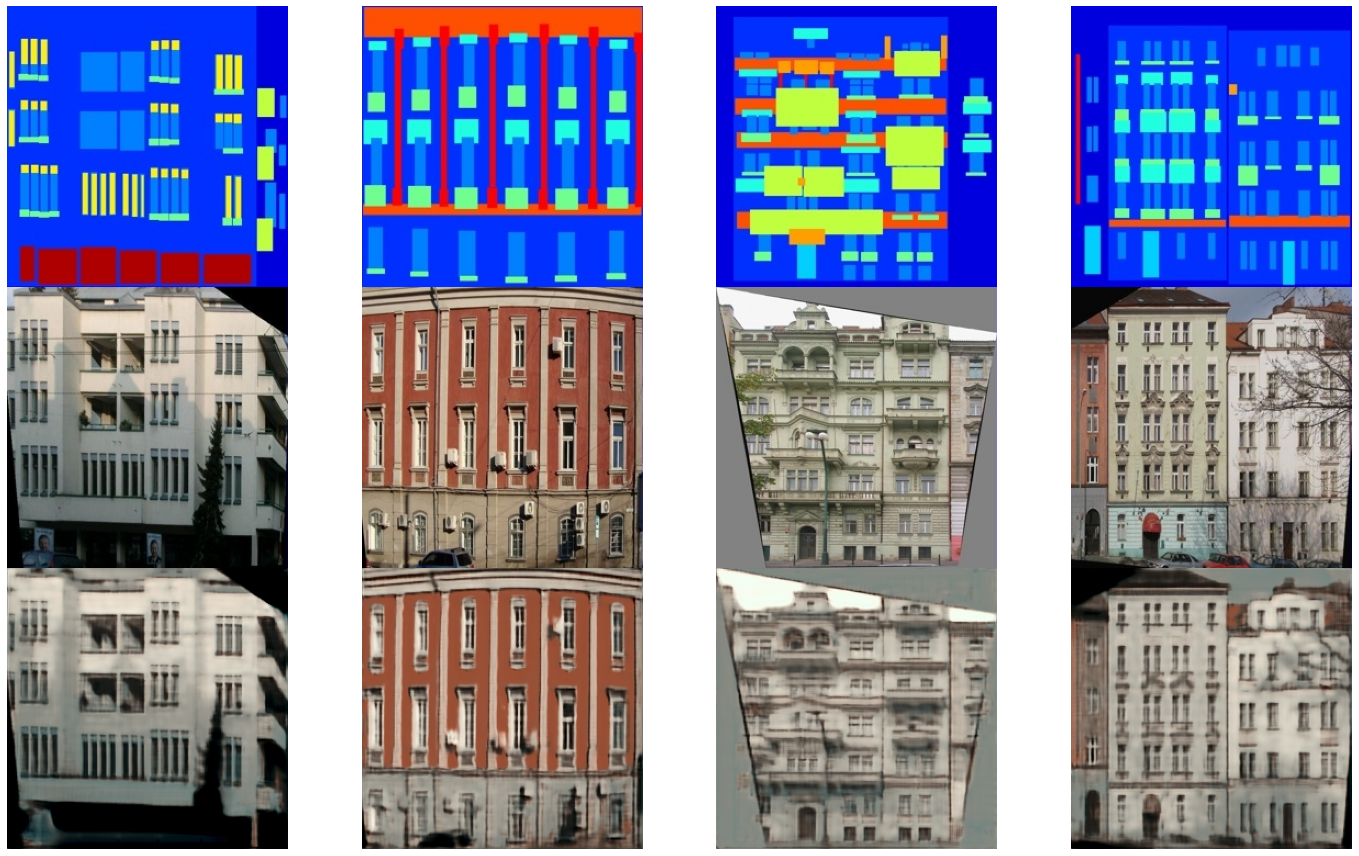

In [23]:
plot_batch_with_results(batch.sketch_images, batch.target_images, batch.predicted_image.detach().cpu())